In [1]:
import pandas as pd
import numpy as np
from sql_export import sql_connection, sql_connection_close
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import os
from dotenv import load_dotenv
# from concurrent import futures
import matplotlib.pyplot as plt
from azure_blob_dataset import AzureBlobDataset
import random
from skimage.transform import rotate
from dl_models import CNNFromScratch, get_efficientnet
import time
import torch.optim as optim
import torch.nn as nn
from rotate import RandomRotation




load_dotenv()

True

## Set PATH for Azure SQL in Jupyter environment

In [2]:
# Set Apple Silicon paths (for M1/M2 Macs)
# For some reason we need to manually set paths for the odbcinst file so jupyter file can connect to Azure SQL
# Did not need to do this for python code

os.environ['ODBCSYSINI'] = os.getenv('ETC')
os.environ['ODBCINSTINI'] = os.getenv("INI")
os.environ['DYLD_LIBRARY_PATH'] = os.getenv("LIB")

In [3]:
!odbcinst -q -d -n "ODBC Driver 18 for SQL Server"

[ODBC Driver 18 for SQL Server]
Description=Microsoft ODBC Driver 18 for SQL Server
Driver=/opt/homebrew/lib/libmsodbcsql.18.dylib
UsageCount=2


## Azure SQL Database Retrieval to memory

In [4]:
sql_connection_close()
sql_query = "SELECT * FROM dbo.galaxy_target_values"
conn, cursor = sql_connection()
target_df = pd.read_sql(sql_query, conn)
target_df
sql_connection_close()

Connection to SQL server successful.
SQL Server version:  Microsoft SQL Azure (RTM) - 12.0.2000.8 
	Feb  9 2025 20:57:20 
	Copyright (C) 2024 Microsoft Corporation

SQL connection closed.
Connection to SQL server successful.
SQL Server version:  Microsoft SQL Azure (RTM) - 12.0.2000.8 
	Feb  9 2025 20:57:20 
	Copyright (C) 2024 Microsoft Corporation



/var/folders/51/q7wk1sc54ms0xz7vq4j4k4g80000gn/T/ipykernel_93007/3625703550.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  target_df = pd.read_sql(sql_query, conn)


Connection to SQL server successful.
SQL Server version:  Microsoft SQL Azure (RTM) - 12.0.2000.8 
	Feb  9 2025 20:57:20 
	Copyright (C) 2024 Microsoft Corporation

SQL connection closed.


In [5]:
target_df

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.000000,0.000000,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.000000,0.000000,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.000000,0.000000,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61573,999948,0.510379,0.489621,0.000000,0.059207,0.430414,0.000000,0.430414,0.226257,0.204157,...,0.000000,0.226257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.226257
61574,999950,0.901216,0.098784,0.000000,0.000000,0.098784,0.000000,0.098784,0.000000,0.098784,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
61575,999958,0.202841,0.777376,0.019783,0.116962,0.660414,0.067245,0.593168,0.140022,0.520391,...,0.000000,0.000000,0.090673,0.049349,0.000000,0.067726,0.000000,0.000000,0.0,0.072296
61576,999964,0.091000,0.909000,0.000000,0.045450,0.863550,0.022452,0.841098,0.795330,0.068220,...,0.000000,0.068398,0.318132,0.408799,0.227464,0.408799,0.090668,0.023065,0.0,0.045334


## Transformations

In [6]:
#transforming the images to tensor and normalizing 
transform_training = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(170/424, 240/424), ratio=(1.0, 1.0)), # scale jittering from center cropping
    RandomRotation(angles = [0, 90, 180, 270]),  # rotate the image on 4 quadrant angles
    transforms.RandomHorizontalFlip(p=0.5), # flip image about horizontal axis 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    transforms.ToTensor(),                # converts numpy array (H,W,C) in [0,1] to tensor (C,H,W)
    # These values were computed over the ImageNet training set. ImageNet is a huge dataset of natural images and has become the standard benchmark
    #  for many image classification models.
    transforms.Normalize(                 # normalized value = (pixel value - mean)/std
        mean=[0.485, 0.456, 0.406],       # These numbers represent the average pixel intensity (scaled between 0 and 1) for each color channel across the entire ImageNet training set.
        std=[0.229, 0.224, 0.225]         # These values indicate how much the pixel intensities vary (standard deviation) from the mean in each channel.
    )
])

In [7]:
# Define evaluation transforms (deterministic)
transform_eval = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

### Dataset Split (80/10/10)

In [8]:
# doing this makes it easire to lookup target values for corresponding images at O(1) time complexity
# Better integration with DataLoader
target_dict = dict(zip(target_df['GalaxyID'], target_df.drop('GalaxyID', axis=1).values))

In [9]:
full_training_dataset = AzureBlobDataset(train=True, transform=transform_training, target_dict=target_dict, img_size=(424, 424))
full_eval_dataset = AzureBlobDataset(train=True, transform=transform_eval, target_dict=target_dict, img_size=(424, 424))

In [10]:
# Get the same split indices for both (you can generate indices and then create Subset objects)
total_size = len(full_training_dataset)
indices = list(range(total_size))
train_split = int(0.8 * total_size)
val_split = int(0.9 * total_size)


train_dataset = torch.utils.data.Subset(full_training_dataset, indices[:train_split])
val_dataset = torch.utils.data.Subset(full_eval_dataset, indices[train_split:val_split])
test_dataset = torch.utils.data.Subset(full_eval_dataset, indices[val_split:])

print(f"Dataset split: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test.")

# Adjust the batch size based on GPU/CPU memory
batch_size = 128  # Increase this value if memory permits

# Determine the number of available CPU cores and reserve one core for the main process.
num_workers = os.cpu_count() - 1 if os.cpu_count() and os.cpu_count() > 1 else 1


print(f"Using batch_size={batch_size} and num_workers={num_workers}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Dataset split: 49262 train, 6158 val, 6158 test.
Using batch_size=128 and num_workers=10


### Sample view

In [11]:
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    
    # Handle case when num_samples is 1
    if num_samples == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        # Get sample
        sample = dataset[i]
        
        # Convert tensor to numpy array and denormalize if needed
        image = sample['image'].numpy()
        
        # For PyTorch CHW format -> Matplotlib HWC format
        if image.shape[0] == 3:  # RGB
            image = image.transpose(1, 2, 0)
        elif image.shape[0] == 1:  # Grayscale
            image = image.squeeze(0)
        
        # Clip values to valid range for display
        image = np.clip(image, 0, 1)
        
        # Show image
        ax.imshow(image)
        ax.axis('off')
        
        # Create title with metadata
        title = f"Galaxy ID: {sample['galaxy_id']}"
        if 'target' in sample:
            title += f"\nTarget: {sample['target'].numpy().round(2)}"
        
        ax.set_title(title, fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [12]:
### TEST ### (remove after done)

# blerg = AzureBlobDataset(train=True, transform=None, target_dict=target_dict, img_size=(424, 424))
# visualize_samples(blerg, num_samples=5)

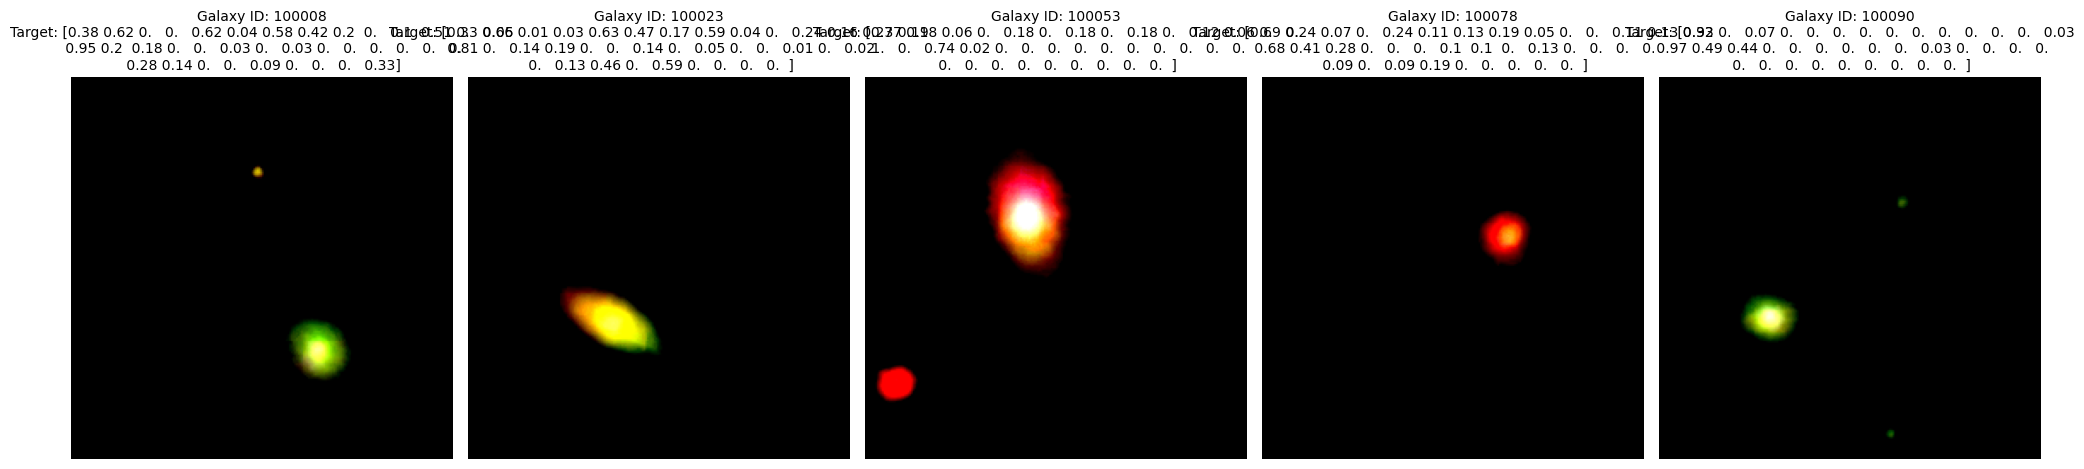

In [13]:
# Visualize first 5 training samples
visualize_samples(train_dataset, num_samples=5)

## DL Model 

### Training Function

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path='best_model.pt'):
    """
    Prints the current epoch, batch progress, and elapsed time.
    Also prints DataLoader settings.
    """
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    # Print DataLoader settings
    print(f"Training DataLoader: batch size = {train_loader.batch_size}, num_workers = {train_loader.num_workers}")
    print(f"Validation DataLoader: batch size = {val_loader.batch_size}, num_workers = {val_loader.num_workers}")
    total_train_batches = len(train_loader)
    
    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        batch_count = 0
        
        print(f"\nStarting Epoch {epoch}/{num_epochs}")
        for batch in train_loader:
            batch_count += 1
            inputs = batch['image'].to(device)
            targets = batch['target'].to(device)  # Expected shape: [batch_size, 37]
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            # Print progress every 10 batches
            if batch_count % 10 == 0 or batch_count == total_train_batches:
                print(f"  Epoch {epoch} [{batch_count}/{total_train_batches}] - Batch Loss: {loss.item():.4f}")
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        val_batches = len(val_loader)
        with torch.no_grad():
            for i, batch in enumerate(val_loader, 1):
                inputs = batch['image'].to(device)
                targets = batch['target'].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * inputs.size(0)
                # Optionally print progress for validation batches
                if i % 10 == 0 or i == val_batches:
                    print(f"  Validation [{i}/{val_batches}] - Batch Loss: {loss.item():.4f}")
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        elapsed = time.time() - start_time
        print(f"Epoch {epoch} completed in {elapsed:.2f}s | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
        
        # Save the best model based on validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), save_path)
            print("Validation loss improved; model checkpoint saved.")
    
    return train_losses, val_losses



### Compute Metrics

In [15]:
def compute_metrics(model, data_loader, device):
  
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['image'].to(device)
            targets = batch['target'].to(device)
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    mse = np.mean((all_preds - all_targets) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(all_preds - all_targets))
    return rmse, mae

### Plotting Function

In [16]:
def plot_loss_curves(train_losses, val_losses):

    epochs = np.arange(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

### Model + Device Selection

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

model_choice = input("Enter model choice (cnn for from-scratch CNN, or efficientnet for EfficientNet): ").strip().lower()

if model_choice == "cnn":
    model = CNNFromScratch(num_outputs=37)
elif model_choice == "efficientnet":
    ver = input("For EfficientNet version please input a number between 0 and 7: ").strip().lower()
    ver = int(ver)
    # For EfficientNet-B0 using torchvision:
    model = get_efficientnet(version=ver, num_outputs=37)
else:
    raise ValueError("Invalid model_choice.")

model.to(device)

/Users/manahilshanzad/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/manahilshanzad/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### Training

In [18]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()  # Using MSE loss for regression of 37 probabilities

num_epochs = 10
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Training DataLoader: batch size = 128, num_workers = 10
Validation DataLoader: batch size = 128, num_workers = 10

Starting Epoch 1/10
  Epoch 1 [10/385] - Batch Loss: 0.0722
  Epoch 1 [20/385] - Batch Loss: 0.0541
  Epoch 1 [30/385] - Batch Loss: 0.0421
  Epoch 1 [40/385] - Batch Loss: 0.0401
  Epoch 1 [50/385] - Batch Loss: 0.0359
  Epoch 1 [60/385] - Batch Loss: 0.0305
  Epoch 1 [70/385] - Batch Loss: 0.0333
  Epoch 1 [80/385] - Batch Loss: 0.0274
  Epoch 1 [90/385] - Batch Loss: 0.0253
  Epoch 1 [100/385] - Batch Loss: 0.0249
  Epoch 1 [110/385] - Batch Loss: 0.0253
  Epoch 1 [120/385] - Batch Loss: 0.0257
  Epoch 1 [130/385] - Batch Loss: 0.0208
  Epoch 1 [140/385] - Batch Loss: 0.0215
  Epoch 1 [150/385] - Batch Loss: 0.0202
  Epoch 1 [160/385] - Batch Loss: 0.0215
  Epoch 1 [170/385] - Batch Loss: 0.0205
  Epoch 1 [180/385] - Batch Loss: 0.0197
  Epoch 1 [190/385] - Batch Loss: 0.0203
  Epoch 1 [200/385] - Batch Loss: 0.0194
  Epoch 1 [210/385] - Batch Loss: 0.0194
  Epoch 1 [22

python(98464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98469) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98471) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98473) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98477) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98479) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98482) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98485) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98487) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98490) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Epoch 2 [10/385] - Batch Loss: 0.0141
  Epoch 2 [20/385] - Batch Loss: 0.0160
  Epoch 2 [30/385] - Batch Loss: 0.0153
  Epoch 2 [40/385] - Batch Loss: 0.0147
  Epoch 2 [50/385] - Batch Loss: 0.0154
  Epoch 2 [60/385] - Batch Loss: 0.0135
  Epoch 2 [70/385] - Batch Loss: 0.0127
  Epoch 2 [80/385] - Batch Loss: 0.0138
  Epoch 2 [90/385] - Batch Loss: 0.0136
  Epoch 2 [100/385] - Batch Loss: 0.0140
  Epoch 2 [110/385] - Batch Loss: 0.0157
  Epoch 2 [120/385] - Batch Loss: 0.0140
  Epoch 2 [130/385] - Batch Loss: 0.0131
  Epoch 2 [140/385] - Batch Loss: 0.0129
  Epoch 2 [150/385] - Batch Loss: 0.0144
  Epoch 2 [160/385] - Batch Loss: 0.0149
  Epoch 2 [170/385] - Batch Loss: 0.0151
  Epoch 2 [180/385] - Batch Loss: 0.0129
  Epoch 2 [190/385] - Batch Loss: 0.0130
  Epoch 2 [200/385] - Batch Loss: 0.0125
  Epoch 2 [210/385] - Batch Loss: 0.0123
  Epoch 2 [220/385] - Batch Loss: 0.0137
  Epoch 2 [230/385] - Batch Loss: 0.0134
  Epoch 2 [240/385] - Batch Loss: 0.0123
  Epoch 2 [250/385] - Bat

python(3712) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3714) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3716) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3720) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3724) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3726) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3731) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3738) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3740) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3742) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Validation [10/49] - Batch Loss: 0.0137
  Validation [20/49] - Batch Loss: 0.0118
  Validation [30/49] - Batch Loss: 0.0138
  Validation [40/49] - Batch Loss: 0.0127
  Validation [49/49] - Batch Loss: 0.0150
Epoch 2 completed in 7950.58s | Train Loss: 0.0133 | Val Loss: 0.0122
Validation loss improved; model checkpoint saved.

Starting Epoch 3/10


python(3864) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3898) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3902) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3904) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3906) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3909) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3911) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3922) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3924) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3926) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Epoch 3 [10/385] - Batch Loss: 0.0114
  Epoch 3 [20/385] - Batch Loss: 0.0115
  Epoch 3 [30/385] - Batch Loss: 0.0110
  Epoch 3 [40/385] - Batch Loss: 0.0112
  Epoch 3 [50/385] - Batch Loss: 0.0112
  Epoch 3 [60/385] - Batch Loss: 0.0113
  Epoch 3 [70/385] - Batch Loss: 0.0121
  Epoch 3 [80/385] - Batch Loss: 0.0104
  Epoch 3 [90/385] - Batch Loss: 0.0098
  Epoch 3 [100/385] - Batch Loss: 0.0104
  Epoch 3 [110/385] - Batch Loss: 0.0110
  Epoch 3 [120/385] - Batch Loss: 0.0114
  Epoch 3 [130/385] - Batch Loss: 0.0113
  Epoch 3 [140/385] - Batch Loss: 0.0119
  Epoch 3 [150/385] - Batch Loss: 0.0113
  Epoch 3 [160/385] - Batch Loss: 0.0108
  Epoch 3 [170/385] - Batch Loss: 0.0121
  Epoch 3 [180/385] - Batch Loss: 0.0112
  Epoch 3 [190/385] - Batch Loss: 0.0117
  Epoch 3 [200/385] - Batch Loss: 0.0113
  Epoch 3 [210/385] - Batch Loss: 0.0099
  Epoch 3 [220/385] - Batch Loss: 0.0103
  Epoch 3 [230/385] - Batch Loss: 0.0121
  Epoch 3 [240/385] - Batch Loss: 0.0101
  Epoch 3 [250/385] - Bat

python(6464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6474) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6491) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6511) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6513) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6515) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6519) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6526) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6528) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6530) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Validation [10/49] - Batch Loss: 0.0130
  Validation [20/49] - Batch Loss: 0.0114
  Validation [30/49] - Batch Loss: 0.0126
  Validation [40/49] - Batch Loss: 0.0117
  Validation [49/49] - Batch Loss: 0.0143
Epoch 3 completed in 4878.49s | Train Loss: 0.0111 | Val Loss: 0.0114
Validation loss improved; model checkpoint saved.

Starting Epoch 4/10


python(6822) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6824) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6827) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6830) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6832) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6834) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6836) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6865) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6867) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6869) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Epoch 4 [10/385] - Batch Loss: 0.0109
  Epoch 4 [20/385] - Batch Loss: 0.0103
  Epoch 4 [30/385] - Batch Loss: 0.0116
  Epoch 4 [40/385] - Batch Loss: 0.0109
  Epoch 4 [50/385] - Batch Loss: 0.0103
  Epoch 4 [60/385] - Batch Loss: 0.0109
  Epoch 4 [70/385] - Batch Loss: 0.0096
  Epoch 4 [80/385] - Batch Loss: 0.0098
  Epoch 4 [90/385] - Batch Loss: 0.0103
  Epoch 4 [100/385] - Batch Loss: 0.0102
  Epoch 4 [110/385] - Batch Loss: 0.0110
  Epoch 4 [120/385] - Batch Loss: 0.0103
  Epoch 4 [130/385] - Batch Loss: 0.0101
  Epoch 4 [140/385] - Batch Loss: 0.0116
  Epoch 4 [150/385] - Batch Loss: 0.0103
  Epoch 4 [160/385] - Batch Loss: 0.0122
  Epoch 4 [170/385] - Batch Loss: 0.0105
  Epoch 4 [180/385] - Batch Loss: 0.0101
  Epoch 4 [190/385] - Batch Loss: 0.0108
  Epoch 4 [200/385] - Batch Loss: 0.0086
  Epoch 4 [210/385] - Batch Loss: 0.0108
  Epoch 4 [220/385] - Batch Loss: 0.0105
  Epoch 4 [230/385] - Batch Loss: 0.0099
  Epoch 4 [240/385] - Batch Loss: 0.0093
  Epoch 4 [250/385] - Bat

python(13047) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13069) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13080) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13082) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13085) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13087) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13089) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13093) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13095) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13097) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Validation [10/49] - Batch Loss: 0.0120
  Validation [20/49] - Batch Loss: 0.0103
  Validation [30/49] - Batch Loss: 0.0120
  Validation [40/49] - Batch Loss: 0.0107
  Validation [49/49] - Batch Loss: 0.0130
Epoch 4 completed in 9376.08s | Train Loss: 0.0101 | Val Loss: 0.0106
Validation loss improved; model checkpoint saved.

Starting Epoch 5/10


python(13202) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13204) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13206) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13210) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13212) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13217) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13223) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13238) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13248) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13253) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Epoch 5 [10/385] - Batch Loss: 0.0090
  Epoch 5 [20/385] - Batch Loss: 0.0089
  Epoch 5 [30/385] - Batch Loss: 0.0087
  Epoch 5 [40/385] - Batch Loss: 0.0094
  Epoch 5 [50/385] - Batch Loss: 0.0114
  Epoch 5 [60/385] - Batch Loss: 0.0098
  Epoch 5 [70/385] - Batch Loss: 0.0102
  Epoch 5 [80/385] - Batch Loss: 0.0088
  Epoch 5 [90/385] - Batch Loss: 0.0097
  Epoch 5 [100/385] - Batch Loss: 0.0091
  Epoch 5 [110/385] - Batch Loss: 0.0094
  Epoch 5 [120/385] - Batch Loss: 0.0109
  Epoch 5 [130/385] - Batch Loss: 0.0104
  Epoch 5 [140/385] - Batch Loss: 0.0093
  Epoch 5 [150/385] - Batch Loss: 0.0095
  Epoch 5 [160/385] - Batch Loss: 0.0110
  Epoch 5 [170/385] - Batch Loss: 0.0098
  Epoch 5 [180/385] - Batch Loss: 0.0083
  Epoch 5 [190/385] - Batch Loss: 0.0093
  Epoch 5 [200/385] - Batch Loss: 0.0109
  Epoch 5 [210/385] - Batch Loss: 0.0093
  Epoch 5 [220/385] - Batch Loss: 0.0098
  Epoch 5 [230/385] - Batch Loss: 0.0100
  Epoch 5 [240/385] - Batch Loss: 0.0094
  Epoch 5 [250/385] - Bat

python(22058) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22065) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22069) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22076) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22079) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22089) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22108) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22128) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22136) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22139) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Validation [10/49] - Batch Loss: 0.0125
  Validation [20/49] - Batch Loss: 0.0110
  Validation [30/49] - Batch Loss: 0.0113
  Validation [40/49] - Batch Loss: 0.0113
  Validation [49/49] - Batch Loss: 0.0123
Epoch 5 completed in 13359.14s | Train Loss: 0.0095 | Val Loss: 0.0108

Starting Epoch 6/10


python(22270) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22283) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22341) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22355) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22365) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22368) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22379) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22395) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22404) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22406) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Epoch 6 [10/385] - Batch Loss: 0.0081
  Epoch 6 [20/385] - Batch Loss: 0.0099
  Epoch 6 [30/385] - Batch Loss: 0.0105
  Epoch 6 [40/385] - Batch Loss: 0.0106
  Epoch 6 [50/385] - Batch Loss: 0.0085
  Epoch 6 [60/385] - Batch Loss: 0.0097
  Epoch 6 [70/385] - Batch Loss: 0.0097
  Epoch 6 [80/385] - Batch Loss: 0.0088
  Epoch 6 [90/385] - Batch Loss: 0.0095
  Epoch 6 [100/385] - Batch Loss: 0.0096
  Epoch 6 [110/385] - Batch Loss: 0.0105
  Epoch 6 [120/385] - Batch Loss: 0.0088
  Epoch 6 [130/385] - Batch Loss: 0.0092
  Epoch 6 [140/385] - Batch Loss: 0.0078
  Epoch 6 [150/385] - Batch Loss: 0.0089
  Epoch 6 [160/385] - Batch Loss: 0.0087
  Epoch 6 [170/385] - Batch Loss: 0.0074
  Epoch 6 [180/385] - Batch Loss: 0.0091
  Epoch 6 [190/385] - Batch Loss: 0.0088
  Epoch 6 [200/385] - Batch Loss: 0.0081
  Epoch 6 [210/385] - Batch Loss: 0.0083
  Epoch 6 [220/385] - Batch Loss: 0.0094
  Epoch 6 [230/385] - Batch Loss: 0.0091
  Epoch 6 [240/385] - Batch Loss: 0.0095
  Epoch 6 [250/385] - Bat

python(23814) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23822) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23878) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23903) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23906) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23913) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23920) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23923) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23925) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23936) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Validation [10/49] - Batch Loss: 0.0111
  Validation [20/49] - Batch Loss: 0.0099
  Validation [30/49] - Batch Loss: 0.0108
  Validation [40/49] - Batch Loss: 0.0102
  Validation [49/49] - Batch Loss: 0.0105
Epoch 6 completed in 3098.53s | Train Loss: 0.0091 | Val Loss: 0.0101
Validation loss improved; model checkpoint saved.

Starting Epoch 7/10


python(24042) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24045) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24048) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24050) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24052) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24054) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24056) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24059) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24061) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24063) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Epoch 7 [10/385] - Batch Loss: 0.0083
  Epoch 7 [20/385] - Batch Loss: 0.0083
  Epoch 7 [30/385] - Batch Loss: 0.0088
  Epoch 7 [40/385] - Batch Loss: 0.0082
  Epoch 7 [50/385] - Batch Loss: 0.0090
  Epoch 7 [60/385] - Batch Loss: 0.0094
  Epoch 7 [70/385] - Batch Loss: 0.0087
  Epoch 7 [80/385] - Batch Loss: 0.0087
  Epoch 7 [90/385] - Batch Loss: 0.0093
  Epoch 7 [100/385] - Batch Loss: 0.0094
  Epoch 7 [110/385] - Batch Loss: 0.0096
  Epoch 7 [120/385] - Batch Loss: 0.0077
  Epoch 7 [130/385] - Batch Loss: 0.0100
  Epoch 7 [140/385] - Batch Loss: 0.0082
  Epoch 7 [150/385] - Batch Loss: 0.0101
  Epoch 7 [160/385] - Batch Loss: 0.0092
  Epoch 7 [170/385] - Batch Loss: 0.0093
  Epoch 7 [180/385] - Batch Loss: 0.0090
  Epoch 7 [190/385] - Batch Loss: 0.0074
  Epoch 7 [200/385] - Batch Loss: 0.0094
  Epoch 7 [210/385] - Batch Loss: 0.0083
  Epoch 7 [220/385] - Batch Loss: 0.0090
  Epoch 7 [230/385] - Batch Loss: 0.0077
  Epoch 7 [240/385] - Batch Loss: 0.0080
  Epoch 7 [250/385] - Bat

python(24504) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24506) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24509) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24512) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24518) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24552) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24567) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24591) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24628) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24641) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Validation [10/49] - Batch Loss: 0.0112
  Validation [20/49] - Batch Loss: 0.0103
  Validation [30/49] - Batch Loss: 0.0103
  Validation [40/49] - Batch Loss: 0.0101
  Validation [49/49] - Batch Loss: 0.0117
Epoch 7 completed in 1562.13s | Train Loss: 0.0087 | Val Loss: 0.0099
Validation loss improved; model checkpoint saved.

Starting Epoch 8/10


python(24724) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24726) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24730) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24732) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24735) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24737) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24739) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24741) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24743) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24745) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Epoch 8 [10/385] - Batch Loss: 0.0084
  Epoch 8 [20/385] - Batch Loss: 0.0080
  Epoch 8 [30/385] - Batch Loss: 0.0093
  Epoch 8 [40/385] - Batch Loss: 0.0089
  Epoch 8 [50/385] - Batch Loss: 0.0085
  Epoch 8 [60/385] - Batch Loss: 0.0089
  Epoch 8 [70/385] - Batch Loss: 0.0082
  Epoch 8 [80/385] - Batch Loss: 0.0098
  Epoch 8 [90/385] - Batch Loss: 0.0078
  Epoch 8 [100/385] - Batch Loss: 0.0084
  Epoch 8 [110/385] - Batch Loss: 0.0086
  Epoch 8 [120/385] - Batch Loss: 0.0093
  Epoch 8 [130/385] - Batch Loss: 0.0083
  Epoch 8 [140/385] - Batch Loss: 0.0084
  Epoch 8 [150/385] - Batch Loss: 0.0091
  Epoch 8 [160/385] - Batch Loss: 0.0085
  Epoch 8 [170/385] - Batch Loss: 0.0080
  Epoch 8 [180/385] - Batch Loss: 0.0087
  Epoch 8 [190/385] - Batch Loss: 0.0079
  Epoch 8 [200/385] - Batch Loss: 0.0091
  Epoch 8 [210/385] - Batch Loss: 0.0080
  Epoch 8 [220/385] - Batch Loss: 0.0080
  Epoch 8 [230/385] - Batch Loss: 0.0086
  Epoch 8 [240/385] - Batch Loss: 0.0090
  Epoch 8 [250/385] - Bat

python(25278) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25286) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25303) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25309) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25326) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25368) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25382) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25384) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25413) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Validation [10/49] - Batch Loss: 0.0111
  Validation [20/49] - Batch Loss: 0.0097
  Validation [30/49] - Batch Loss: 0.0104
  Validation [40/49] - Batch Loss: 0.0096
  Validation [49/49] - Batch Loss: 0.0121
Epoch 8 completed in 1727.66s | Train Loss: 0.0084 | Val Loss: 0.0095
Validation loss improved; model checkpoint saved.

Starting Epoch 9/10


python(25474) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25476) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25478) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25480) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25482) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25503) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25506) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25508) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25511) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25513) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Epoch 9 [10/385] - Batch Loss: 0.0080
  Epoch 9 [20/385] - Batch Loss: 0.0078
  Epoch 9 [30/385] - Batch Loss: 0.0080
  Epoch 9 [40/385] - Batch Loss: 0.0080
  Epoch 9 [50/385] - Batch Loss: 0.0077
  Epoch 9 [60/385] - Batch Loss: 0.0080
  Epoch 9 [70/385] - Batch Loss: 0.0081
  Epoch 9 [80/385] - Batch Loss: 0.0078
  Epoch 9 [90/385] - Batch Loss: 0.0094
  Epoch 9 [100/385] - Batch Loss: 0.0084
  Epoch 9 [110/385] - Batch Loss: 0.0078
  Epoch 9 [120/385] - Batch Loss: 0.0086
  Epoch 9 [130/385] - Batch Loss: 0.0078
  Epoch 9 [140/385] - Batch Loss: 0.0091
  Epoch 9 [150/385] - Batch Loss: 0.0082
  Epoch 9 [160/385] - Batch Loss: 0.0084
  Epoch 9 [170/385] - Batch Loss: 0.0101
  Epoch 9 [180/385] - Batch Loss: 0.0078
  Epoch 9 [190/385] - Batch Loss: 0.0080
  Epoch 9 [200/385] - Batch Loss: 0.0081
  Epoch 9 [210/385] - Batch Loss: 0.0074
  Epoch 9 [220/385] - Batch Loss: 0.0091
  Epoch 9 [230/385] - Batch Loss: 0.0094
  Epoch 9 [240/385] - Batch Loss: 0.0094
  Epoch 9 [250/385] - Bat

python(26347) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26349) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26352) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26354) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26356) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26358) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26361) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26365) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26371) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26376) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Validation [10/49] - Batch Loss: 0.0105
  Validation [20/49] - Batch Loss: 0.0098
  Validation [30/49] - Batch Loss: 0.0097
  Validation [40/49] - Batch Loss: 0.0096
  Validation [49/49] - Batch Loss: 0.0102
Epoch 9 completed in 2001.45s | Train Loss: 0.0083 | Val Loss: 0.0094
Validation loss improved; model checkpoint saved.

Starting Epoch 10/10


python(26481) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26483) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26485) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26487) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26490) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26492) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26494) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26496) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26498) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26500) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Epoch 10 [10/385] - Batch Loss: 0.0074
  Epoch 10 [20/385] - Batch Loss: 0.0080
  Epoch 10 [30/385] - Batch Loss: 0.0090
  Epoch 10 [40/385] - Batch Loss: 0.0089
  Epoch 10 [50/385] - Batch Loss: 0.0075
  Epoch 10 [60/385] - Batch Loss: 0.0081
  Epoch 10 [70/385] - Batch Loss: 0.0091
  Epoch 10 [80/385] - Batch Loss: 0.0072
  Epoch 10 [90/385] - Batch Loss: 0.0086
  Epoch 10 [100/385] - Batch Loss: 0.0084
  Epoch 10 [110/385] - Batch Loss: 0.0076
  Epoch 10 [120/385] - Batch Loss: 0.0076
  Epoch 10 [130/385] - Batch Loss: 0.0066
  Epoch 10 [140/385] - Batch Loss: 0.0071
  Epoch 10 [150/385] - Batch Loss: 0.0084
  Epoch 10 [160/385] - Batch Loss: 0.0087
  Epoch 10 [170/385] - Batch Loss: 0.0074
  Epoch 10 [180/385] - Batch Loss: 0.0071
  Epoch 10 [190/385] - Batch Loss: 0.0085
  Epoch 10 [200/385] - Batch Loss: 0.0079
  Epoch 10 [210/385] - Batch Loss: 0.0087
  Epoch 10 [220/385] - Batch Loss: 0.0078
  Epoch 10 [230/385] - Batch Loss: 0.0080
  Epoch 10 [240/385] - Batch Loss: 0.0080
 

python(27055) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27058) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27060) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27066) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27069) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27076) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27162) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27183) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27187) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27191) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Validation [10/49] - Batch Loss: 0.0101
  Validation [20/49] - Batch Loss: 0.0097
  Validation [30/49] - Batch Loss: 0.0094
  Validation [40/49] - Batch Loss: 0.0094
  Validation [49/49] - Batch Loss: 0.0101
Epoch 10 completed in 1876.61s | Train Loss: 0.0080 | Val Loss: 0.0090
Validation loss improved; model checkpoint saved.


### Visualiztion

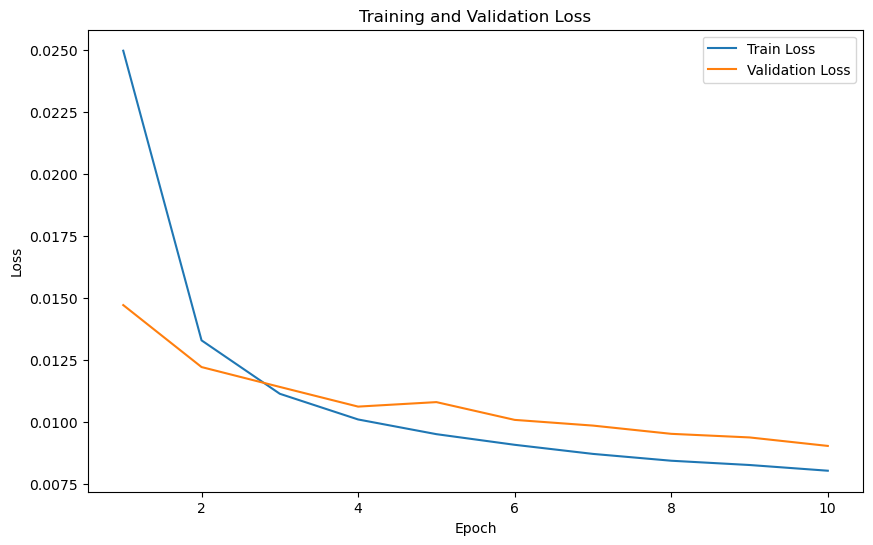

In [19]:
plot_loss_curves(train_losses, val_losses)

### Compute Metrics 

In [20]:
rmse, mae = compute_metrics(model, test_loader, device)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

python(27264) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27267) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27269) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27271) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27273) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27275) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27278) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27280) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27282) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27285) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Test RMSE: 0.0956
Test MAE: 0.0557
